In [78]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.layers import GRU
import tensorflow as tf
import math
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from sklearn.metrics import mean_squared_error

In [79]:
def plot_predictions(test,predicted):
    plt.figure(figsize = (10,6))
    plt.plot(test, color='red',label='Real Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Stock Price')
    plt.title('Amazon Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Amazon Stock Price')
    plt.legend()
    plt.show()

In [80]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [81]:
dataset = pd.read_csv('goog1.csv', index_col='Date', parse_dates=['Date']) 
dataset.tail()

,Close,High,Low,Open,Adj Close,Volume
Date,,,,,,
2019-04-26,1272.180054,1273.069946,1260.319946,1269.000000,1272.180054,1241400
2019-04-29,1287.579956,1289.270020,1266.295044,1274.000000,1287.579956,2499400
2019-04-30,1188.479980,1192.810059,1175.000000,1185.000000,1188.479980,6207000
2019-05-01,1168.079956,1188.050049,1167.180054,1188.050049,1168.079956,2639200
2019-05-02,1162.609985,1174.189941,1155.001953,1167.760010,1162.609985,1943700


In [45]:
dataset=dataset.drop(['Volume'],axis=1) # Original Data

In [82]:
dataset.head(2)

,Close,High,Low,Open,Adj Close,Volume
Date,,,,,,
2013-05-02,412.124542,414.578552,406.878632,407.400269,412.124542,4062700
2013-05-03,420.127472,420.663971,415.298889,415.775787,420.127472,5057800


# Technical Analysis

In [83]:

    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = pd.stats.moments.rolling_std(dataset['Close'],20)
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
 
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
    


/Users/san/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).std()
  from ipykernel import kernelapp as app


In [84]:
def RSI(series, period):
 delta = series.diff().dropna() #daily positive differences, i.e. gains.
 u = delta * 0                 
 d = u.copy()                   #daily negative difference, i.e. losses

 u[delta > 0] = delta[delta > 0] #Average daily positive differences for the period specified.
 d[delta < 0] = -delta[delta < 0] #Average daily negative difference for the period specified
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / \
 pd.stats.moments.ewma(d, com=period-1, adjust=False)
 return 100 - 100 / (1 + rs)

In [85]:
dataset['RSI'] = RSI(dataset['Close'], 14)
dataset.head()

/Users/san/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=13,min_periods=0,adjust=False,ignore_na=False).mean()
  if sys.path[0] == '':
/Users/san/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=13,min_periods=0,adjust=False,ignore_na=False).mean()
  del sys.path[0]


,Close,High,Low,Open,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,RSI
Date,,,,,,,,,,,,,,,,,
2013-05-02,412.124542,414.578552,406.878632,407.400269,412.124542,4062700,NaN,NaN,412.124542,412.124542,0.000000,NaN,NaN,NaN,412.124542,411.124542,NaN
2013-05-03,420.127472,420.663971,415.298889,415.775787,420.127472,5057800,NaN,NaN,416.279910,416.459462,0.179553,NaN,NaN,NaN,418.126739,419.127472,NaN
2013-05-06,427.991333,428.140350,421.389282,421.389282,427.991333,4310300,NaN,NaN,420.487710,420.960354,0.472644,NaN,NaN,NaN,424.956073,426.991333,NaN
2013-05-07,425.845276,429.143829,422.586487,428.716614,425.845276,3943400,NaN,NaN,421.985452,422.502333,0.516882,NaN,NaN,NaN,425.556285,424.845276,NaN
2013-05-08,433.992310,434.116486,423.699249,425.731018,433.992310,4968600,NaN,NaN,424.769892,425.624119,0.854227,NaN,NaN,NaN,431.203541,432.992310,NaN


In [86]:
print('Total dataset has {} samples, and {} features.'.format(dataset.shape[0], \
                                                              dataset.shape[1]))

Total dataset has 1511 samples, and 17 features.


In [87]:
dataset

,Close,High,Low,Open,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,RSI
Date,,,,,,,,,,,,,,,,,
2013-05-02,412.124542,414.578552,406.878632,407.400269,412.124542,4062700,NaN,NaN,412.124542,412.124542,0.000000,NaN,NaN,NaN,412.124542,411.124542,NaN
2013-05-03,420.127472,420.663971,415.298889,415.775787,420.127472,5057800,NaN,NaN,416.279910,416.459462,0.179553,NaN,NaN,NaN,418.126739,419.127472,NaN
2013-05-06,427.991333,428.140350,421.389282,421.389282,427.991333,4310300,NaN,NaN,420.487710,420.960354,0.472644,NaN,NaN,NaN,424.956073,426.991333,NaN
2013-05-07,425.845276,429.143829,422.586487,428.716614,425.845276,3943400,NaN,NaN,421.985452,422.502333,0.516882,NaN,NaN,NaN,425.556285,424.845276,NaN
2013-05-08,433.992310,434.116486,423.699249,425.731018,433.992310,4968600,NaN,NaN,424.769892,425.624119,0.854227,NaN,NaN,NaN,431.203541,432.992310,NaN
2013-05-09,432.924255,436.987823,431.309753,432.606323,432.924255,4429700,NaN,NaN,426.403145,427.398436,0.995290,NaN,NaN,NaN,432.352260,431.924255,NaN
2013-05-10,437.270966,437.424957,433.262054,434.826874,437.270966,3820000,427.182308,NaN,428.335931,429.601456,1.265525,NaN,NaN,NaN,435.632897,436.270966,NaN
2013-05-13,435.929688,438.383728,433.868103,436.605316,435.929688,2915700,430.583043,NaN,429.559473,430.922061,1.362587,NaN,NaN,NaN,435.830788,434.929688,NaN
2013-05-14,440.683777,441.473633,435.735962,435.914795,440.683777,3179000,433.519658,NaN,431.208339,432.853276,1.644936,NaN,NaN,NaN,439.066278,439.683777,NaN


In [88]:
dataset = dataset[~np.isnan(dataset).any(axis=1)]

In [89]:
dataset.head()

,Close,High,Low,Open,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,RSI
Date,,,,,,,,,,,,,,,,,
2013-05-31,432.795074,435.666412,430.957031,431.255096,432.795074,3964400,435.530857,436.816309,437.923179,437.449146,-0.474034,9.419660,455.655628,417.976989,432.801322,431.795074,60.041462
2013-06-03,431.011688,434.161194,424.747437,433.679321,431.011688,4983500,433.984488,437.715697,437.295820,436.433014,-0.862806,8.609199,454.934094,420.497299,431.608233,430.011688,58.207940
2013-06-04,426.774231,432.482117,424.275482,431.120972,426.774231,3761400,432.303279,438.032209,436.356455,434.914482,-1.441973,8.692001,455.416211,420.648207,428.385565,425.774231,53.989167
2013-06-05,427.072296,431.915802,425.795624,428.468231,427.072296,4240900,431.336709,437.988445,435.539982,433.685694,-1.854288,8.601584,455.191614,420.785276,427.510052,426.072296,54.240400
2013-06-06,429.526337,430.365875,420.872620,429.357452,429.526337,5191600,430.156525,438.163734,435.018361,433.035814,-1.982547,8.783423,455.730580,420.596888,428.854242,428.526337,56.353506


In [90]:
print('Total dataset has {} samples, and {} features.'.format(dataset.shape[0], \
                                                              dataset.shape[1]))

Total dataset has 1491 samples, and 17 features.


In [91]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10))
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    

    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.plot(dataset['RSI'],label='RSI', color='b',linestyle='--')

    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=.35)
    plt.title('Technical indicators for google - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    plt.legend()
    plt.show()

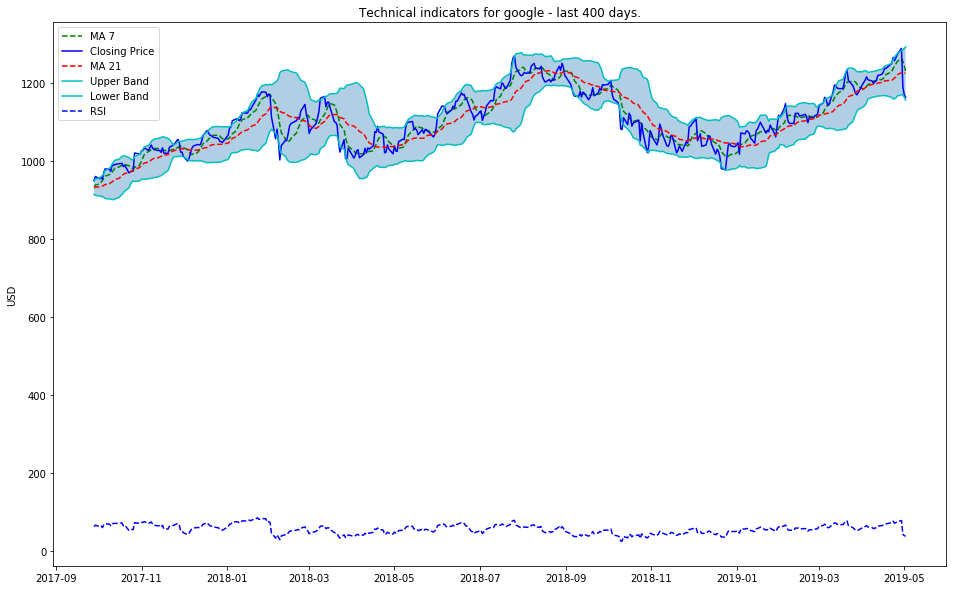

In [92]:
plot_technical_indicators(dataset, 400)

# Feature Selection

In [93]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [94]:
(X_train, y_train), (X_test, y_test) = get_feature_importance_data(dataset)

In [95]:
import xgboost as xgb

regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)


In [96]:
xgbModel = regressor.fit(X_train,y_train,eval_set = [(X_train, y_train), (X_test, y_test)], \
                         verbose=False)

In [97]:
eval_result = regressor.evals_result()

In [98]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

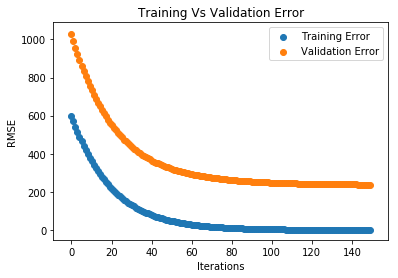

In [99]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

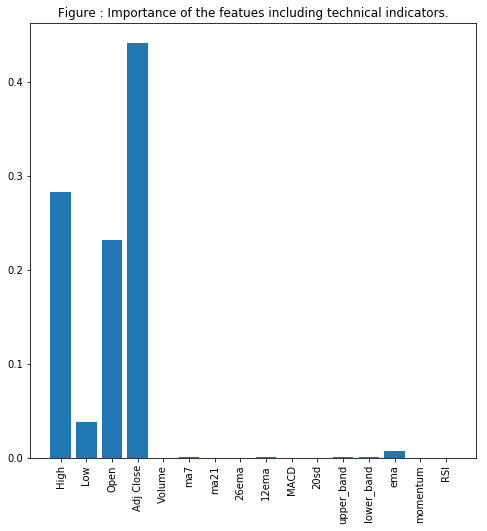

In [100]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test.columns)
plt.title('Figure : Importance of the featues including technical indicators.')
plt.show()